[DEBUG][PennyStockData]: Imputed len(data): 104295
next_max_date: 2024-06-01


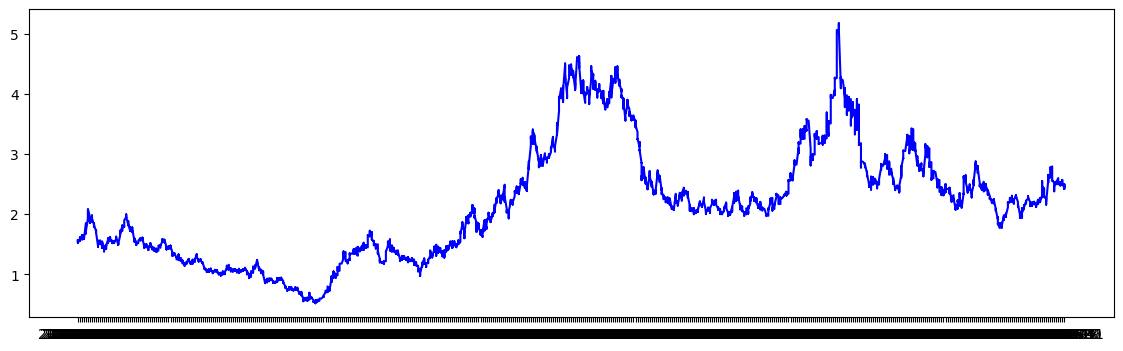

In [1]:
from pennystockpipeline.PennyStockSingleTickerData import PennyStockSingleTickerData
import numpy as np
import pandas as pd
from time import gmtime, strftime
from datetime import datetime, timedelta

## Initializing
DATABASE_NAME_WITH_PATH = "mod_historicaldata.db"
TABLE_NAME = "all_historical_modified"

#psd = PennyStockData(database_name_with_path, table_name, impute=True, verbose=2).get_columns(columns).normalize(['close', 'volume_weighted_average']).create_sequences(sequence_length, prediction_length)
psd = PennyStockSingleTickerData(DATABASE_NAME_WITH_PATH, TABLE_NAME, impute=True, verbose=2).plot_data()


In [2]:
import torch
#columns = ['ticker_id', 'p_date', 'close', 'volume_weighted_average']
COLUMNS = ['ticker_id', 'p_date', 'p_time', 'volume_weighted_average']
COLUMNS_TO_NORMALIZE = ['volume_weighted_average']

SEQUENCE_LENGTH = 20
PREDICTION_LENGTH = 20

TRAIN_TEST_SPLIT = 0.8
psd = psd.get_columns(COLUMNS).normalize(COLUMNS_TO_NORMALIZE).create_sequences(SEQUENCE_LENGTH, PREDICTION_LENGTH).split_dataset(split=TRAIN_TEST_SPLIT, to_torch=True)


[INFO][PennyStockData]: Performing ticker-wise normalization on ['volume_weighted_average']
max_value: 5.1712
[INFO][PennyStockData]: Performing global normalization on ['volume_weighted_average'] using MixMaxScaler
x_train.shape: (3964, 20, 1), y_train.shape: (3964, 20, 1)
x_test.shape: (991, 20, 1), y_test.shape: (991, 20, 1)


In [3]:
# Library for implementing Deep Neural Network 
from pennystockpipeline.PennyStockSingleTickerModel import PennyStockSingleTickerModel

# Prepare model parameters
INPUT_SIZE = len(COLUMNS_TO_NORMALIZE)
NUM_LAYERS = 2
HIDDEN_SIZE = 64
OUTPUT_SIZE = len(COLUMNS_TO_NORMALIZE)

# Define the model, loss function, and optimizer
model = PennyStockSingleTickerModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, device='cuda')
model = model.to(model.device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)



PennyStockSingleTickerModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [4]:
BATCH_SIZE = 16

# Pass the dataset and prepare the dataloaders
model = model.create_dataloaders(psd, BATCH_SIZE)


Epoch [10/50] - Training Loss: 0.0001, Test Loss: 0.0002
Epoch [20/50] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [30/50] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [40/50] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [50/50] - Training Loss: 0.0001, Test Loss: 0.0001


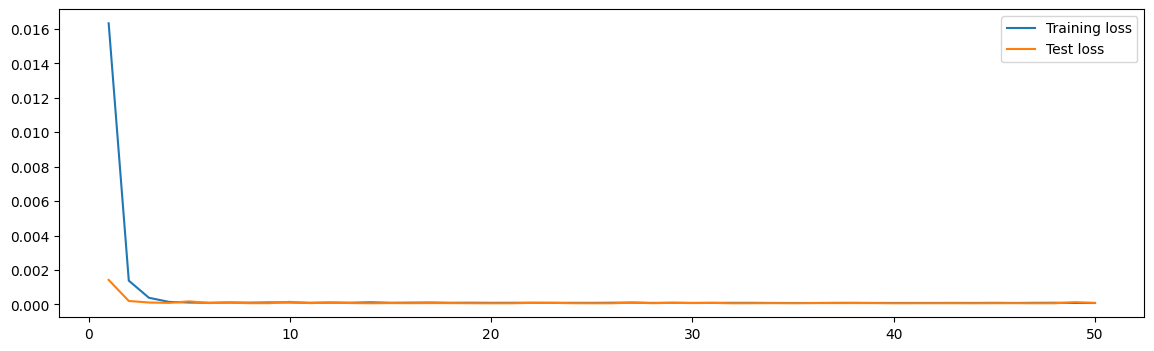

In [5]:
NUM_EPOCHS = 50
# Train the model
model = model.train_model(loss_fn, optimizer, num_epochs = NUM_EPOCHS).plot_training_test_loss()


In [6]:
FORECAST_STEPS = 20
model = model.forecast(num_forecast_steps = FORECAST_STEPS)

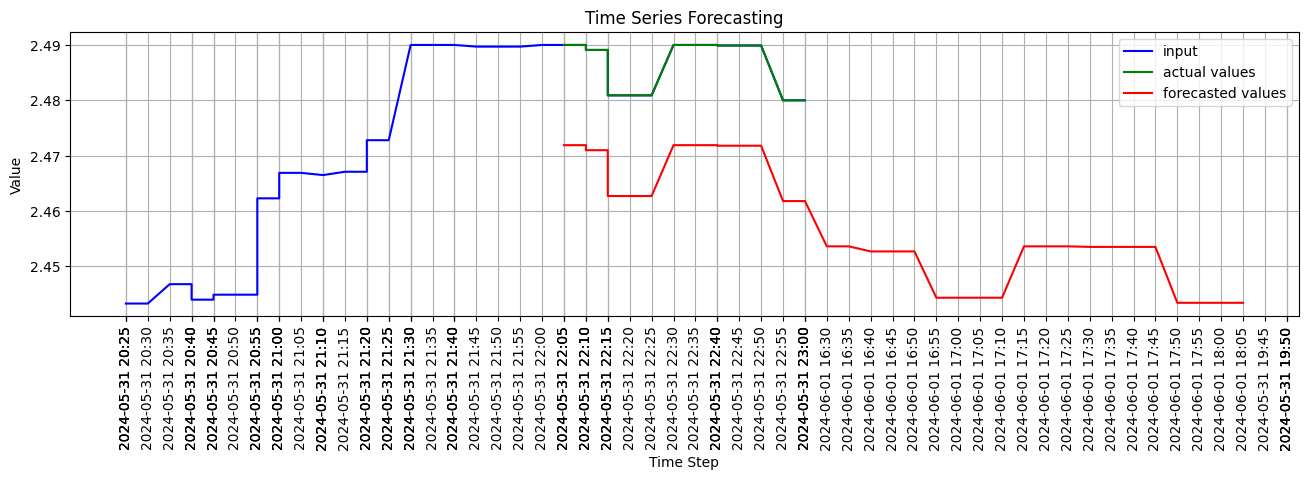

In [7]:
model = model.plot_forecasting()

In [8]:
'''
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization


def plot_forecasting(model):
        forecasted_values = model.forecasted_values

        #print(model.psd_ds_dates)
        #print(model.psd_ds_times)
    
        psd_ds_dates = model.psd_ds_dates[-100:]
        psd_ds_times = model.psd_ds_times[-100:]
    
        # last 100 rows
        psd_ds_datetimes = []
        
        [psd_ds_datetimes.append(d + " " + t) for d,t in zip(psd_ds_dates, psd_ds_times)]

        #print(f'{psd_ds_datetimes}')

        test_data_x = np.float32(model.psd.scaler.inverse_transform(model.psd.x_test.squeeze()).reshape(-1, 1).squeeze())
        #print(len(test_data_x))
        #print(type(test_data_x), test_data_x.shape)
        
        sequence_to_plot = model.sequence_to_plot
        
        model_psd_data_df = pd.DataFrame(model.psd.data, columns=model.psd.headers)
        
        #set the size of the plot 
        plt.rcParams['figure.figsize'] = [14, 4] 
        
        #Test data
        plt.plot(psd_ds_datetimes[-80:-20], test_data_x[-60:], label = "input", color = "b") 
        #print(psd_ds_datetimes[-100:-40])
        #reverse the scaling transformation
        original_cases = model.psd.scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0))#.flatten() 
        #original_cases = model.psd.scaler.inverse_transform(np.expand_dims(sequence_to_plot, axis=0))#.flatten() 
        original_cases = original_cases.reshape(-1, 1).squeeze()

        #the historical data used as input for forecasting
        #plt.plot(psd_ds_datetimes[-40:], test_data_x[-40:], label='actual values', color='green') 
        plt.plot(psd_ds_datetimes[-40:-20], original_cases, label='actual values', color='green')
        #print(psd_ds_datetimes[-60:-40])
        
        #Forecasted Values 
        #reverse the scaling transformation
        forecasted_cases = model.psd.scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
        # plotting the forecasted values
        plt.plot(psd_ds_datetimes[-40:], forecasted_cases, label='forecasted values', color='red') 
        #print(psd_ds_datetimes[-40:])

        #print(type(original_cases[0]), np.finfo(type(original_cases[0])).precision)
        #print(type(test_data_x[0]), np.finfo(type(test_data_x[0])).precision)
        #print(type(forecasted_cases[0]), np.finfo(type(forecasted_cases[0])).precision)
    
        
        plt.xlabel('Time Step')
        plt.ylabel('Value')
    
        plt.xticks(psd_ds_datetimes, psd_ds_datetimes, rotation='vertical')
        plt.locator_params(axis='x', nbins=len(psd_ds_datetimes))
        plt.tight_layout(pad=4)
        plt.subplots_adjust(bottom=0.15)
    
        plt.legend()
        plt.title('Time Series Forecasting')
        plt.grid(True)

        print(f'original_cases: {original_cases}')
        print(f'test_data_x: {test_data_x[-20:]}')

        #print("-===========-")
        
        #print(f'test_data_x:')
        #print(f'{test_data_x[-20:]}')
        print(f'forecasted_cases (first 20 cases:')
        print(f'{forecasted_cases[-40:-20]}')

        return model

model = plot_forecasting(model)#, i_sequence_to_plot, i_forecasted_values, i_combined_index)
'''

'\nimport matplotlib.pyplot as plt # Visualization \nimport matplotlib.dates as mdates # Formatting dates\nimport seaborn as sns # Visualization\n\n\ndef plot_forecasting(model):\n        forecasted_values = model.forecasted_values\n\n        #print(model.psd_ds_dates)\n        #print(model.psd_ds_times)\n    \n        psd_ds_dates = model.psd_ds_dates[-100:]\n        psd_ds_times = model.psd_ds_times[-100:]\n    \n        # last 100 rows\n        psd_ds_datetimes = []\n        \n        [psd_ds_datetimes.append(d + " " + t) for d,t in zip(psd_ds_dates, psd_ds_times)]\n\n        #print(f\'{psd_ds_datetimes}\')\n\n        test_data_x = np.float32(model.psd.scaler.inverse_transform(model.psd.x_test.squeeze()).reshape(-1, 1).squeeze())\n        #print(len(test_data_x))\n        #print(type(test_data_x), test_data_x.shape)\n        \n        sequence_to_plot = model.sequence_to_plot\n        \n        model_psd_data_df = pd.DataFrame(model.psd.data, columns=model.psd.headers)\n        \n  